# Name: Kunal Ghosh

# Course: M.Tech (Aerospace Engineering)

# Subject: Machine Learning (E0-270)

# SAP No.: 6000007645

# S.R. No.: 05-01-00-10-42-22-1-21061

*****************************************************

# Importing the required Libraries

In [1]:
import numpy as np

In [2]:
import torch

In [3]:
import torch.nn as nn

In [4]:
import torch.optim as optim

In [5]:
from torch.autograd import Variable

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
import matplotlib.pyplot as plt

In [8]:
import pandas as pd

## Reading the data from the file

In [9]:
Training_Set = pd.read_csv('Canada.csv')

## Displaying the training set

In [10]:
Training_Set

,Date,T_idx,N,D,S,I,R
0,2020-01-22,0,37799407,0,37799407,0,0
1,2020-01-23,1,37799407,0,37799407,0,0
2,2020-01-24,2,37799407,0,37799407,0,0
3,2020-01-25,3,37799407,0,37799407,0,0
4,2020-01-26,4,37799407,0,37799406,1,0
...,...,...,...,...,...,...,...
183,2020-07-23,183,37799407,8918,37685022,105467,8918
184,2020-07-24,184,37799407,8922,37684305,106180,8922
185,2020-07-25,185,37799407,8928,37683950,106529,8928
186,2020-07-26,186,37799407,8933,37683631,106843,8933


## Factor N, Factor S, Factor I and Factor R will be used in  PINNs

## Factor N

In [11]:
Factor = Training_Set.to_numpy()
Factor_N = max(Factor[:,2])
Factor_N

37799407

## Dropping the columns of data which will NOT be used in training the Neural Network

In [12]:
Training_Set = Training_Set.drop("Date",axis=1)
Training_Set = Training_Set.drop("T_idx",axis=1)
Training_Set = Training_Set.drop("N",axis=1)
Training_Set = Training_Set.drop("D",axis=1)
Training_Set

,S,I,R
0,37799407,0,0
1,37799407,0,0
2,37799407,0,0
3,37799407,0,0
4,37799406,1,0
...,...,...,...
183,37685022,105467,8918
184,37684305,106180,8922
185,37683950,106529,8928
186,37683631,106843,8933


In [13]:
Factor_S_Temp = Training_Set.to_numpy()
Factor_S = max(Factor_S_Temp[:,0])-min(Factor_S_Temp[:,0])

In [14]:
Factor_I_Temp = Training_Set.to_numpy()
Factor_I = max(Factor_I_Temp[:,1])-min(Factor_I_Temp[:,1])

In [15]:
Factor_R_Temp = Training_Set.to_numpy()
Factor_R = max(Factor_R_Temp[:,2])-min(Factor_R_Temp[:,2])

## Factor S

In [16]:
Factor_S

116458

## Factor I

In [17]:
Factor_I

107514

## Factor R

In [18]:
Factor_R

8944

## Normalizing the data

In [19]:
Normalizing = MinMaxScaler()
training_data = Normalizing.fit_transform(Training_Set)

## Dataloading

## We will be using a sliding time window approach. So, preparing the data for that.

## The Sliding_Time_Windows(data, Sequence_Length) function will create each data points for training the neural networks (Both LSTM and PINNs)

## Each data point consist of k days of data (stored in x) and the data of $(k+1)^{th}$ day as the target variable (stored in y). In the code, we have used k = Sequence_Length.
## NOTE: We are having three variables S, I and R in the data

In [20]:
def Sliding_Time_Windows(Data, Seq_Length):

    x = []
    y = []

    for i in range(len(Data)-Seq_Length-1):
        x_temp = Data[i:(i+Seq_Length),:]
        y_temp = Data[i+Seq_Length,:]
        x.append(x_temp)
        y.append(y_temp)

    return np.array(x),np.array(y)

# Declaring the value of k (Sequence_Length)

In [21]:
Sequence_Length = 4
x, y = Sliding_Time_Windows(training_data, Sequence_Length)

## Shape of the data

In [22]:
x.shape

(183, 4, 3)

## Shape of the target variable

In [23]:
y.shape

(183, 3)

## Splitting the data into training set and test set

## Amount of data used for training

In [24]:
Training_Data_Amount = 0.67

In [25]:
train_size = int(len(y) * Training_Data_Amount)
test_size = len(y) - train_size

## Converting the data to the tensors and creating the training set as well as test set

In [26]:
Data_X = Variable(torch.Tensor(np.array(x)))
Data_Y = Variable(torch.Tensor(np.array(y)))

In [27]:
Train_X = Variable(torch.Tensor(np.array(x[0:train_size])))
Train_Y = Variable(torch.Tensor(np.array(y[0:train_size])))

In [28]:
Test_X = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
Test_Y = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Plotting the actual data

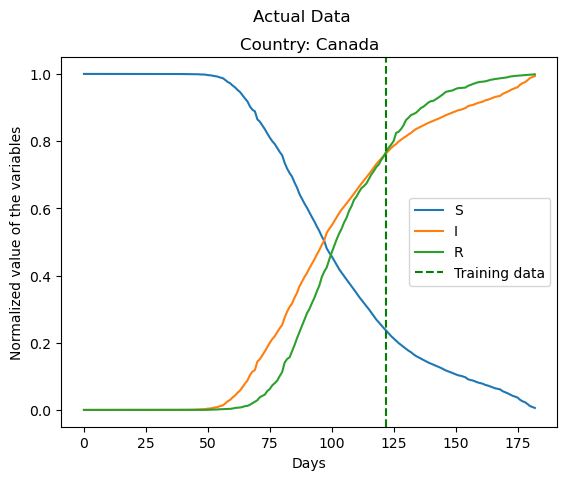

In [29]:
dataY_plot = Data_Y.data.numpy()
plt.plot(dataY_plot)
plt.axvline(x=train_size, c='g', linestyle='--')
plt.suptitle('Actual Data')
plt.title('Country: Canada')
plt.legend(["S","I","R","Training data"])
plt.xlabel("Days")
plt.ylabel("Normalized value of the variables")
plt.show()

## Creating an LSTM class for the LSTM network

In [30]:
class LSTM(nn.Module):
    def __init__(self, Size_Of_Inputs, Neurons_in_LSTM_Layer, Num_Layers, Size_Of_Outputs):
        super(LSTM, self).__init__()
        self.Neurons_in_LSTM_Layer = Neurons_in_LSTM_Layer
        self.Num_Layers = Num_Layers
        self.lstm = nn.LSTM(Size_Of_Inputs, Neurons_in_LSTM_Layer, Num_Layers, batch_first=True)
        self.FC = nn.Linear(Neurons_in_LSTM_Layer, Size_Of_Outputs)

    def forward(self, X):
        H0 = torch.zeros(self.Num_Layers, X.size(0), self.Neurons_in_LSTM_Layer).to(X.device)
        C0 = torch.zeros(self.Num_Layers, X.size(0), self.Neurons_in_LSTM_Layer).to(X.device)
        OUT, _ = self.lstm(X, (H0, C0))
        OUT = self.FC(OUT[:, -1, :])
        return OUT

## Size of the input (It should be 3 because we have three variables S, I and R)

In [31]:
input_size = 3

## Size of the output (It should be 3 because we want to predict three variables S, I and R)

In [32]:
output_size = 3

## Number of the LSTM layers to be used

In [33]:
Num_LSTM_Layers = 2

## Number of neurons in LSTM layer

In [34]:
Num_Neurons_LSTM_Layer = 20

## Creating the LSTM network

In [35]:
LSTM_model = LSTM(input_size,Num_Neurons_LSTM_Layer,Num_LSTM_Layers,output_size)

## Loss function for the LSTM network

In [36]:
Loss_Function = nn.MSELoss()
# Loss_Function = nn.L1Loss()

## Learning Rate

In [37]:
Learning_Rate = 0.0001

## Optimizer for LSTM network

In [38]:
optimizer = optim.Adam(LSTM_model.parameters(), lr=Learning_Rate)

## Training the LSTM model

## Number of the epochs

In [39]:
Num_Epochs = 14000

In [40]:
torch.manual_seed(0)
for epoch in range(Num_Epochs):
    Outputs = LSTM_model(Train_X)
    optimizer.zero_grad()  
    loss = Loss_Function(Outputs, Train_Y)
    loss.backward()
    optimizer.step()
    if epoch % 250 == 0:
        print(f"Number of epochs: {epoch}\nLoss: {loss.item()}\n")

Number of epochs: 0
Loss: 0.33874133229255676

Number of epochs: 250
Loss: 0.13133107125759125

Number of epochs: 500
Loss: 0.05780916288495064

Number of epochs: 750
Loss: 0.04018811881542206

Number of epochs: 1000
Loss: 0.004352519288659096

Number of epochs: 1250
Loss: 0.0009548240923322737

Number of epochs: 1500
Loss: 0.0008291841368190944

Number of epochs: 1750
Loss: 0.0007727380725555122

Number of epochs: 2000
Loss: 0.0007208723109215498

Number of epochs: 2250
Loss: 0.0006698743673041463

Number of epochs: 2500
Loss: 0.0006189357955008745

Number of epochs: 2750
Loss: 0.0005670988466590643

Number of epochs: 3000
Loss: 0.0005131550715304911

Number of epochs: 3250
Loss: 0.0004558018990792334

Number of epochs: 3500
Loss: 0.00039410762838087976

Number of epochs: 3750
Loss: 0.0003283419064246118

Number of epochs: 4000
Loss: 0.0002610369410831481

Number of epochs: 4250
Loss: 0.00019779613649006933

Number of epochs: 4500
Loss: 0.00014631815429311246

Number of epochs: 4750
L

## Comparing the actual data with the predicted data on the test dataset

In [41]:
def Time_Step_Update(outputs,Train_X):
    outputs = outputs.unsqueeze(1)
    Train_X_clone = Train_X.clone().detach()
    Train_X_clone_1 = Train_X_clone[:,1:,:]
    temp = torch.cat((Train_X_clone_1,outputs),dim = 1)
    return temp

In [42]:
LSTM_model.eval()
Data_LSTM = Test_X
Future_len = 10
for i in range(Future_len):
    train_predict_LSTM = LSTM_model(Data_LSTM)
    Data_LSTM = Time_Step_Update(train_predict_LSTM,Data_LSTM)

In [43]:
data_predict_LSTM = train_predict_LSTM.data.numpy()
dataY_plot = Test_Y.data.numpy()

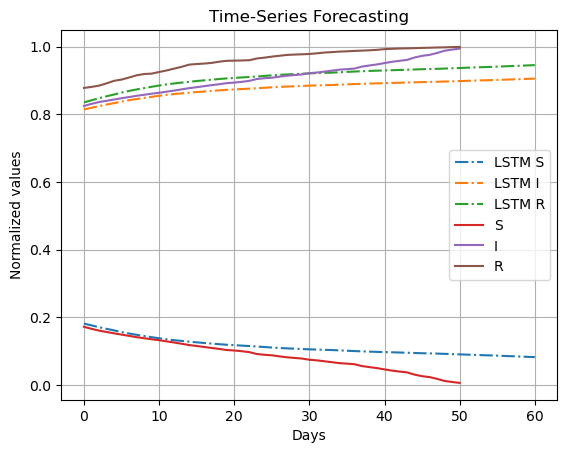

In [44]:
plt.plot(data_predict_LSTM,linestyle= "-.")
plt.plot(dataY_plot[Future_len:,:])
plt.legend(["LSTM S","LSTM I","LSTM R","S","I","R"])
plt.title('Time-Series Forecasting')
plt.xlabel("Days")
plt.ylabel("Normalized values")
plt.grid()
plt.savefig("LSTM.png")
plt.show()

## Saving the parameters of LSTM Model

In [45]:
torch.save(LSTM_model,f"LSTM_MSE_LR_{Learning_Rate}_Epochs_{epoch}\
_seq_{Sequence_Length}_train_amount_{Training_Data_Amount}_Num_LSTM_Layers_\
{Num_LSTM_Layers}_Num_Neurons_LSTM_Layer_{Num_Neurons_LSTM_Layer}_.pth")

*********************************

# Physics Informed Neural Network (PINN)

## Defining the Custom loss function for PINN (L1 Loss)

In [46]:
def PINN_Loss_Function_SIR_L1(outputs, inputs, a, b, Factor_N, Factor_S, Factor_I, Factor_R):
    
    # Define model inputs
    S = inputs[:, 0]
    I = inputs[:, 1]
    R = inputs[:, 2]

    # Define model outputs
    S_pred = outputs[:,0]
    I_pred = outputs[:,1]
    R_pred = outputs[:,2]

    # Compute differential equations using the original values
    dS_dt = (-a*S*I*Factor_I)/Factor_N
    dI_dt = (a*S*I*Factor_S)/Factor_N - b*I
    dR_dt = (b*I*Factor_I/Factor_R)

    # Compute differential equations using the predicted values
    dS_dt_pred = (-a*S_pred*I_pred*Factor_I)/Factor_N
    dI_dt_pred = (a*S_pred*I_pred*Factor_S)/Factor_N - b*I_pred
    dR_dt_pred = (b*I_pred*Factor_I/Factor_R)
    
    # Compute loss function
    loss = (torch.mean(torch.abs((dS_dt_pred - dS_dt))) + \
           torch.mean(torch.abs((dI_dt_pred - dI_dt)*(Factor_I/Factor_S))) + \
           torch.mean(torch.abs((dR_dt_pred - dR_dt)*(Factor_R/Factor_S)))) + \
           torch.mean(torch.abs(S_pred - S)) + \
           torch.mean(torch.abs((I_pred - I)*(Factor_I/Factor_S))) + \
           torch.mean(torch.abs((R_pred - R)*(Factor_R/Factor_S)))

    return loss

## Defining the Custom loss function for PINN (MSE Loss)

In [47]:
def PINN_Loss_Function_SIR_MSE(outputs, inputs,a,b,Factor_N,Factor_S,Factor_I,Factor_R):
    
    # Define model inputs
    S = inputs[:, 0]
    I = inputs[:, 1]
    R = inputs[:, 2]

    # Define model outputs
    S_pred = outputs[:,0]
    I_pred = outputs[:,1]
    R_pred = outputs[:,2]

    # Compute differential equations using the original values
    dS_dt = (-a*S*I*Factor_I)/Factor_N
    dI_dt = (a*S*I*Factor_S)/Factor_N - b*I
    dR_dt = (b*I*Factor_I/Factor_R)

    # Compute differential equations using the predicted values
    dS_dt_pred = (-a*S_pred*I_pred*Factor_I)/Factor_N
    dI_dt_pred = (a*S_pred*I_pred*Factor_S)/Factor_N - b*I_pred
    dR_dt_pred = (b*I_pred*Factor_I/Factor_R)
    
    # Compute loss function
    loss = (torch.mean(torch.square((dS_dt_pred - dS_dt))) + \
           torch.mean(torch.square((dI_dt_pred - dI_dt)*(Factor_I/Factor_S)**2)) + \
           torch.mean(torch.square((dR_dt_pred - dR_dt)*(Factor_R/Factor_S)**2))) + \
           torch.mean(torch.square(S_pred - S)) + \
           torch.mean(torch.square((I_pred - I)*(Factor_I/Factor_S)**2)) + \
           torch.mean(torch.square((R_pred - R)*(Factor_R/Factor_S)**2))

    return loss

## Creating the PINN

In [48]:
Physics_Informed_model = LSTM(input_size,Num_Neurons_LSTM_Layer,Num_LSTM_Layers,output_size)

## Optimizer for PINN

In [49]:
optimizer = optim.Adam(Physics_Informed_model.parameters(), lr=Learning_Rate)

## Training the PINN model

## Number of the epochs

In [50]:
Num_Epochs = 10000

## Infection rate

In [51]:
a = 0.03

## Recovery rate

In [52]:
b = 0.00005

In [53]:
torch.manual_seed(0)
for epoch in range(Num_Epochs):
    outputs = Physics_Informed_model(Train_X)
    optimizer.zero_grad()
    loss = PINN_Loss_Function_SIR_MSE(outputs, Train_Y,a,b,Factor_N,Factor_S,Factor_I,Factor_R)
    # loss = PINN_Loss_Function_SIR_L1(outputs, Train_Y,a,b,Factor_N,Factor_S,Factor_I,Factor_R)
    loss.backward()
    optimizer.step()
    if epoch % 250 == 0:
        print(f"Number of epochs: {epoch}\nLoss: {loss.item()}\n")

Number of epochs: 0
Loss: 0.496025949716568

Number of epochs: 250
Loss: 0.13331173360347748

Number of epochs: 500
Loss: 0.08797959238290787

Number of epochs: 750
Loss: 0.05752529203891754

Number of epochs: 1000
Loss: 0.007950923405587673

Number of epochs: 1250
Loss: 0.0008450091700069606

Number of epochs: 1500
Loss: 0.0007011437555775046

Number of epochs: 1750
Loss: 0.0006358582759276032

Number of epochs: 2000
Loss: 0.0005953919026069343

Number of epochs: 2250
Loss: 0.0005649508093483746

Number of epochs: 2500
Loss: 0.0005375672481022775

Number of epochs: 2750
Loss: 0.0005105331656523049

Number of epochs: 3000
Loss: 0.00048307463293895125

Number of epochs: 3250
Loss: 0.0004551461315713823

Number of epochs: 3500
Loss: 0.0004269155324436724

Number of epochs: 3750
Loss: 0.0003985800431109965

Number of epochs: 4000
Loss: 0.0003703096299432218

Number of epochs: 4250
Loss: 0.0003422235604375601

Number of epochs: 4500
Loss: 0.000314387958496809

Number of epochs: 4750
Loss: 

## Comparing the actual data with the predicted data on the test dataset

In [54]:
Physics_Informed_model.eval()
LSTM_model.eval()
Data_PINN = Test_X
Data_LSTM = Test_X
Future_len = 10
for i in range(Future_len):
    train_predict_PINN = Physics_Informed_model(Data_PINN)
    train_predict_LSTM = LSTM_model(Data_LSTM)
    Data_PINN = Time_Step_Update(train_predict_PINN,Data_PINN)
    Data_LSTM = Time_Step_Update(train_predict_LSTM,Data_LSTM)

In [55]:
data_predict_PINN = train_predict_PINN.data.numpy()
data_predict_LSTM = train_predict_LSTM.data.numpy()
dataY_plot = Test_Y.data.numpy()

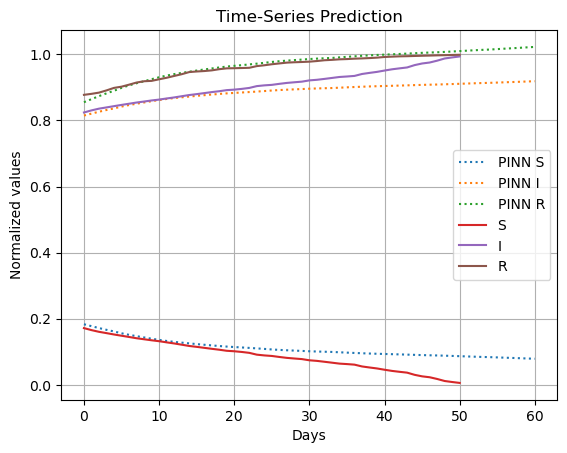

In [56]:
plt.title('Time-Series Prediction')
plt.plot(data_predict_PINN,linestyle= ":")
plt.plot(dataY_plot[Future_len:,:])
plt.legend(["PINN S","PINN I","PINN R","S","I","R"])
plt.xlabel("Days")
plt.ylabel("Normalized values")
plt.grid()
plt.savefig("PINN.jpg")
plt.show()

## Saving the parameters of PINN Model

In [57]:
torch.save(Physics_Informed_model,f"PINN_MSE_LR_{Learning_Rate}_Epochs_{epoch}\
_seq_{Sequence_Length}_train_amount_{Training_Data_Amount}_Num_LSTM_Layers_\
{Num_LSTM_Layers}_Num_Neurons_LSTM_Layer_{Num_Neurons_LSTM_Layer}_.pth")

*****************************************

# Comparision of LSTM and PINN

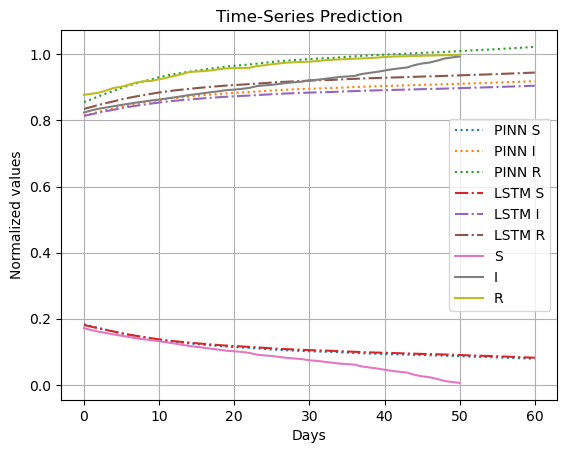

In [58]:
plt.title('Time-Series Prediction')
plt.plot(data_predict_PINN,linestyle= ":")
plt.plot(data_predict_LSTM,linestyle= "-.")
plt.plot(dataY_plot[Future_len:,:])
plt.legend(["PINN S","PINN I","PINN R","LSTM S","LSTM I","LSTM R","S","I","R"])
plt.xlabel("Days")
plt.ylabel("Normalized values")
plt.grid()
plt.savefig("LSTM_vs_PINN.jpg")
plt.show()

************************************************